# A quick analysis of the EIP-1559-style fee mechanism in Filecoin

[Davide Crapis](https://twitter.com/DavideCrapis)

**Main Variables**

There are 3 types of variables that are relevant for the Filecoin fee market:

- set by user: gas_fee_cap,	gas_premium, gas_limit

- set by protocol: parent_base_fee

- calculated by protocol: gas_used, gas_refund, gas_burned, base_fee_burn, over_estimation_burn

A few relations between these variables are clear from their [implementation](https://github.com/filecoin-project/lotus/blob/v0.10.0/chain/vm/burn.go#L70-L102), the following is particularly useful `gas_limit = gas_used + gas_refund + gas_burned`.

**Filecoin Fee Mechanism**

[User fees](https://github.com/filecoin-project/lotus/blob/v0.10.0/chain/vm/burn.go#L70-L102) are similar to Ethereum, with an additional component - number (3) below - that is burned to explicitly disincentivize overestimation of gas used - beyond the implicit disincentive of number (2). The total cost of a transaction is:

(1) GasUsage * BaseFee (burned) +

(2) GasLimit * GasPremium (storage provider’s reward) +

(3) OverEstimationBurn * BaseFee (burned)

The [basefee update mechanism](https://github.com/filecoin-project/lotus/blob/65ee059591c10c7d89565cc3d8dfcffbfb148593/chain/store/basefee.go#L16) in filecoin is the same as Ethereum's EIP-1559. In particular, the [current parameters](https://github.com/filecoin-project/lotus/blob/65ee059591c10c7d89565cc3d8dfcffbfb148593/build/params_shared_vals.go#L121) specify a gas limit of 10B gas units and a gas target of 5B gas units per block. The base fee update formula is

$$
b_{n+1} = b_n \left( 1  + \frac{1}{8} \cdot \frac{g_n - g^*}{g^*}\right),
$$

where $g_n$ is the average amount of gas consumed by a block in tipset $n$ and $g^*$ is the sustainable gas target of 5B (possibly scaled by packing efficiency coefficient, in which case the target is 4B).

This mechanism was initially [proposed by Vitalik](https://ethresear.ch/t/first-and-second-price-auctions-and-improved-transaction-fee-markets/2410) as an improvement to the previous Ethereum mechanism, a simple first-price auction where miners kept all the fees. It was implemented by Filecoin even before Ethereum itself! The mechanism has a few desirable practical properties:

- Simple bidding strategies for users and inclusion strategies for miners are incentive compatible. (Thus making the protocol robust against economic attacks and manipulations.)

- Reduced variance of fees and improved predictability.

- Burning base fees further reduces incentives to manipulate for miners and native token inflation. (Alternatively, capturing them as protocol revenue can increase flexibility, protocol can decide distribution policy, over time to different participants.)

- The update mechanism ensures that average block size is kept close to a sustainable target, which is typically smaller than maximum block burst limit.

We will conduct an EDA with an eye at these properties. We will then propose further directions for more in depth analyses that can potentially give better measurements of these properties and generate ideas for new mechanisms that improve upon the current one.

## EDA

**Data**

Means and aggregate data are not granular enough to carry on a satisfactory analysis of the blockspace market. In order to gain a good understanding of how the fee mechanism works in practice and the dynamics induced by users interacting with it we need to get granular data.

Fortunately, we can leverage open data and tooling built in the PL ecosystem. We leverage the Sentinel system and download [Lily data dumps](https://lilium.sh/data/dumps/) files from the fil-archive public s3 buckets. For this exercise we focus on one of the most interesting days identified in high level exploratory analysis (June 11th 2021). Looking at the [data model](https://lilium.sh/data/models/#derived_gas_outputs) we identify 3 main tables of interest:

- block_headers: get unix timestamp
- block_messages: get messages
- derived_gas_outputs: message details

Notes: 
- We won't be using the first table but it is useful if one wants to reconstruct what happened in UTC time by linking block height to the time it was added;
- The epoch time in Filecoin is 30 seconds and there are five blocks in a tipset on expectation. A tipset is a set of blocks that each have the same height and parent tipset; the Filecoin blockchain is a [chain of tipsets](https://filecoin.io/blog/posts/tipsets-a-closer-look-at-filecoin-building-blocks). Each tipset is assigned a weight corresponding to the amount of storage the network is provided per the commitments encoded in the tipset’s blocks.

In [6]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

In [32]:
bm_messages = "height,block,message"
bm_cols = bm_messages.split(",")

bm = pd.read_csv('block_messages-2021-06-11.csv', names=bm_cols)
bm.shape

(3410301, 3)

In [33]:
# blocks and messages per tipset
bm.groupby('height').nunique().reset_index().describe()

,height,block,message
count,2859.000000,2859.000000,2859.000000
mean,836880.735922,4.923400,517.805876
std,831.968699,2.179989,129.726740
min,835441.000000,1.000000,42.000000
25%,836160.500000,3.000000,441.000000
50%,836880.000000,5.000000,509.000000
75%,837601.500000,6.000000,591.000000
max,838320.000000,16.000000,1102.000000


We notice that there are too many messages, this is because in the Filecoin blockchain, multiple blocks in a single tipset may [include the same message](https://spec.filecoin.io/systems/filecoin_vm/interpreter/). Messages are processed only the first time they are encountered in the tipset’s canonical order, subsequent duplicates do not result in any state mutation, produce a receipt, or pay gas to the block producer. We thus exclude them before merging with derived gas outputs.

In [5]:
bmm = bm[~bm[['message']].duplicated()]
bmm.shape

(1480407, 3)

In [34]:
dgo_header = "height,cid,state_root,from,to,value,gas_fee_cap,gas_premium,gas_limit,\
size_bytes,nonce,method,actor_name,actor_family,exit_code,gas_used,parent_base_fee,\
base_fee_burn,over_estimation_burn,miner_penalty,miner_tip,refund,gas_refund,gas_burned"
dgo_cols = dgo_header.split(",")

dgo = pd.read_csv('derived_gas_outputs-2021-06-11.csv', names=dgo_cols)
dgo.shape

(1463902, 24)

In [39]:
gf = bmm[['block','message']].merge(dgo, left_on='message', right_on='cid', how='left')
gf.shape

(1480407, 26)

In [73]:
gf1 = gf[['height','block','gas_used','parent_base_fee']].groupby(['height']).agg({'gas_used': np.sum, 'block': 'nunique', 'parent_base_fee': np.mean}).reset_index()
gf1['avg_gas_per_block'] = gf1['gas_used'] / gf1['block']
gf1.head(15)

,height,gas_used,block,parent_base_fee,avg_gas_per_block
0,835441.0,1.645633e+10,4,1.384664e+09,4.114083e+09
1,835442.0,1.962443e+10,5,1.389373e+09,3.924886e+09
2,835443.0,1.774932e+10,5,1.383129e+09,3.549865e+09
3,835444.0,1.378103e+10,3,1.361956e+09,4.593678e+09
4,835445.0,1.564567e+10,5,1.384518e+09,3.129134e+09
5,835446.0,1.827184e+10,6,1.345610e+09,3.045307e+09
6,835447.0,1.204632e+10,2,1.305119e+09,6.023161e+09
7,835448.0,1.914485e+10,8,1.389064e+09,2.393106e+09
8,835449.0,7.866642e+09,1,1.317775e+09,7.866642e+09
9,835450.0,7.933401e+09,1,1.482228e+09,7.933401e+09


The table above shows the dynamic fee mechanism at work! We can see how when the avg gas per block is above the 4B threshold the protocol increases the base fee and when it is below it decreases it.

The table below shows that the mechanism does a good job at keeping avg gas per block on track with the 4B gas units target (average deviation over the entire day is less than 1%). This can also be appreciated by the first chart below where we plot the rolling average. 

In [53]:
gf1.describe()

,height,gas_used,block,parent_base_fee,avg_gas_per_block
count,2858.000000,2.858000e+03,2858.000000,2.858000e+03,2.858000e+03
mean,836880.232330,1.706467e+10,4.822603,1.328703e+09,4.043909e+09
std,831.678352,4.746997e+09,2.078362,8.240803e+08,1.462103e+09
min,835441.000000,2.009423e+09,1.000000,6.414598e+08,1.004711e+09
25%,836160.250000,1.394034e+10,3.000000,9.048156e+08,2.943712e+09
50%,836879.500000,1.654535e+10,5.000000,1.036600e+09,3.758718e+09
75%,837600.750000,1.986468e+10,6.000000,1.336636e+09,4.878757e+09
max,838319.000000,3.910842e+10,14.000000,6.273926e+09,8.426587e+09


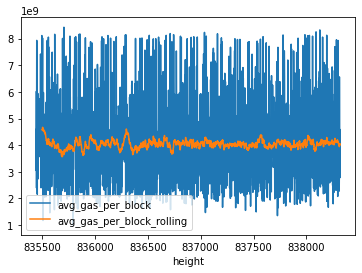

In [111]:
gf1['avg_gas_per_block_rolling'] = gf1['avg_gas_per_block'].rolling(60).mean()
gf1.plot('height',['avg_gas_per_block','avg_gas_per_block_rolling'])
plt.show()

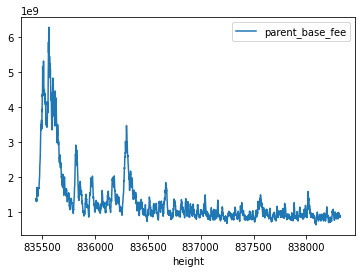

In [57]:
gf1.plot('height',['parent_base_fee'])
plt.show()

In [112]:
gf1['parent_base_fee'].corr(gf1['avg_gas_per_block']).round(3)

-0.034

In [113]:
gf1['parent_base_fee'].corr(gf1['avg_gas_per_block_rolling']).round(3)

0.293

The final insight we focus on is looking more in detail at how the basefee relates to congestion. We can see that there is a negative correlation of -3.4% between base fee and avg gas per block, this is because higher fee locally suppresses demand. At the same time we see that there is a strong positive correlation of 29.3% between base fee and the rolling average, showing that basefee is a signal of network congestion.

## Further directions

There are many more exciting hypothesis tests and improvements that can be worked out from this granular data. These crucially depend on the priority of problems faced by the Filecoin blockchain as the network scales. Here are a few directions that seem relevant:

- Structural demand estimation, including potential demand and the mempool, elasticities, load on different types of resources.

- Parameter updates to current base fee update rule, including dynamic updates, smoothing to reduce volatility and spikiness that is currently observed.

- Heterogeneous resource pricing to improve efficiency and UX, including pricing different VM resources (e.g. storage and compute) or differentiated pricing for specific types of messages and transactions.

More broadly, there are other related questions that seem to be relevant and potentially very impactful:

- New mechanisms that are tailored to the specificity and scale of the Filecoin blockchain as new components are built (e.g. Hierarchical Consensus or HyperDrive). Perhaps a new framework so that the mechanism can be easily upgraded as the chain itself evolves.

- Macroeconomic policy changes, including tweaking the current "burn all base fees", updating miner rewards/punishment schemes. These need to be carefully designed and tested with network revenue as well as inflation in mind.